# Task 3: Results comparison

This notebook implements an evaluation to compare the performance of the models when detecting Maltese traffic signs.

The four models evaluated are:
1. YOLOv8
2. YOLOv11
3. FasterRCNN
4. RF-DETR

The metrics calculated are:
1. mAP at IoU 50:95
2. mAP at IoU 50
3. mAP at IoU 70
4. Precision
5. Recall
6. F1 score

## Import all the necessary libraries

In [14]:
from __future__ import annotations

#  Standard library
import importlib
import subprocess
import sys

#  Package bootstrap helper
def ensure_package(pkg: str, import_name: str | None = None, pip_name: str | None = None):
    try:
        return importlib.import_module(import_name or pkg)
    except ImportError:
        pip_target = pip_name or pkg
        print(f"Installing missing package: {pip_target}")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", pip_target],
            stdout=subprocess.DEVNULL
        )
        return importlib.import_module(import_name or pkg)

# Ensure third-party packages
torch = ensure_package("torch")
np = ensure_package("numpy")
ensure_package("pycocotools")
ensure_package("ultralytics")
ensure_package("albumentations")
ensure_package("matplotlib")
ensure_package("transformers")


# Explicit imports (clear & IDE-friendly)
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import torch
import numpy as np
from torch.utils.data import DataLoader
from ultralytics import YOLO
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import DetrImageProcessor, DetrForObjectDetection


# Custom/local utilities
try:
   from stefania_livori_utils import *
except ImportError:
   raise ImportError(
       "❌ 'stefania_livori_utils' not found.\n"
       "Make sure 'stefania_livori_utils.py' is in the working directory "
       "or on PYTHONPATH."
   )

#  Reproducibility
torch.manual_seed(42)

print("Environment ready: all dependencies installed and imported.")


Environment ready: all dependencies installed and imported.


## Declare the device

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Uncomment for Colab Run

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')


In [17]:
# import os
# os.chdir('drive/MyDrive')

## Evaluating YOLO architectures

In [18]:
DATA_YAML = "Assignment Material/YOLO_COCO/data.yaml"

# loading our trained yolov8 model
yolov8_model = YOLO("runs/detect/models/yolov8_final/weights/best.pt")

yolov8_metrics = yolov8_model.val(data=DATA_YAML, split="test")

Ultralytics 8.4.7  Python-3.10.19 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
Model summary (fused): 93 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 3111.6523.6 MB/s, size: 2152.2 KB)
val: Scanning D:\Uni\Computer-Vision-2\Assignment Material\YOLO_COCO\labels\test.cache... 116 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 116/116  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.4it/s 3.4s0.2ss
                   all        116        130      0.888      0.665      0.736      0.592
Blind-Spot Mirror (Convex)         14         15      0.926      0.867      0.865       0.74
    No Entry (One Way)         37         40       0.78      0.725      0.784      0.586
No Through Road (T-Sign)          7          7      0.968      0.571       0.73      0.508
   Pedestrian Crossing         22         25      0.803       0.72        0.8      0.632
     

In [19]:
# loading our trained yolov11 model
yolov11_model = YOLO(r"runs/detect/models/yolov11_final/wieghts/best.pt")


yolov11_metrics = yolov11_model.val(data=DATA_YAML, split="test")


Ultralytics 8.4.7  Python-3.10.19 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
YOLO11m summary (fused): 126 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 3138.6548.4 MB/s, size: 2006.9 KB)
val: Scanning D:\Uni\Computer-Vision-2\Assignment Material\YOLO_COCO\labels\test.cache... 116 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 116/116  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.4it/s 3.4s0.2ss
                   all        116        130       0.58      0.618      0.684      0.527
Blind-Spot Mirror (Convex)         14         15      0.586      0.867      0.808      0.644
    No Entry (One Way)         37         40      0.526      0.775       0.72      0.554
No Through Road (T-Sign)          7          7      0.615      0.461      0.676      0.458
   Pedestrian Crossing         22         25      0.801      0.642      0.754      0.526
  

In [20]:
# calculating mean f1s

f1_per_class_v8 = yolov8_metrics.box.f1  # list of f1 scores per class
f1_per_class_v11 = yolov11_metrics.box.f1

# getting the f1 score across all classes
mean_f1_v8 = np.mean(f1_per_class_v8)
mean_f1_v11 = np.mean(f1_per_class_v11)



## Evaluating FasterRCNN

In [21]:
ANNOTATION_FILE_TEST = "Assignment Material/COCO-based_COCO/annotations/test.json"
DATA_DIR_TEST = "Assignment Material/COCO-based_COCO/images/test"
with open(ANNOTATION_FILE_TEST, "r") as f:
    data = json.load(f)
CLASS_ID_TO_NAME = {cat["id"]: cat["name"] for cat in data["categories"]}
NUM_CLASSES = len(CLASS_ID_TO_NAME) + 1
model = get_faster_rcnn(NUM_CLASSES)
model.load_state_dict(
    torch.load(r".\models\faster_rcnn\FINAL_epochs25_lr_0.005_momentum_0.9_weight_0.0005_faster_rcnn.pt", map_location=device)
)

C:\Users\user\AppData\Local\Temp\ipykernel_19296\3597665315.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(r".\models\faster_rcnn\FINAL_epochs25_lr_0.005_mom

<All keys matched successfully>

In [22]:
@torch.no_grad()
def evaluate_map(model, data_loader, device, coco_gt):
    model.eval()
    coco_results = []

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for target, output in zip(targets, outputs):
            image_id = int(target["image_id"])
            boxes = output["boxes"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()

            for box, score, label in zip(boxes, scores, labels):
                coco_results.append({
                    "image_id": image_id,
                    "category_id": int(label),
                    "bbox": [
                        float(box[0]),
                        float(box[1]),
                        float(box[2] - box[0]),
                        float(box[3] - box[1]),
                    ],
                    "score": float(score),
                })

    # Load results into COCO API
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    map_stats = coco_eval.stats
    
    # Precision and Recall at IoU 0.50
    prec_matrix = coco_eval.eval['precision']
    rec_matrix = coco_eval.eval['recall']

    p_at_50 = np.mean(prec_matrix[0, :, :, 0, 2][prec_matrix[0, :, :, 0, 2] > -1])
    r_at_50 = np.mean(rec_matrix[0, :, 0, 2][rec_matrix[0, :, 0, 2] > -1])
    
    # F1 Calculation at IoU 0.50
    f1_at_50 = 2 * (p_at_50 * r_at_50) / (p_at_50 + r_at_50) if (p_at_50 + r_at_50) > 0 else 0

    return {
        "mAP5095": map_stats[0],
        "mAP50": map_stats[1],
        "mAP75": map_stats[2],
        "precision": p_at_50,
        "recall": r_at_50,
        "f1": f1_at_50
    }

In [23]:
# get map50-95, map50, map75 and store them as variables
# get precision and recall and store as variables
# get f1 and store as a variable
model.to(device)
model.eval()
coco_gt = COCO(ANNOTATION_FILE_TEST)

transform = A.Compose(
    [
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format="coco",
        label_fields=["labels"]
    )
)

test_dataset = SignsDataset(
    root=DATA_DIR_TEST,
    annFile=ANNOTATION_FILE_TEST,
    transforms=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    # Batch collate function to handle variable-size images
    collate_fn=lambda x: tuple(zip(*x))
)
# Run the fixed evaluation
results_faster_rcnn = evaluate_map(model, test_loader, device, coco_gt)

c:\Users\user\anaconda3\envs\ari50\lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

## Evaluating RF-DETR

In [ ]:
from ultralytics import RTDETR

RF_DETR_CHECKPOINT_PATH = "models_best_weights/RF-DETR/best.pt" 

results_rf_detr = {
    "mAP5095": 0.0,
    "mAP50": 0.0,
    "mAP75": 0.0,
    "precision": 0.0,
    "recall": 0.0,
    "f1": 0.0
}

if os.path.exists(RF_DETR_CHECKPOINT_PATH):
    try:
        print(f"Loading RF-DETR from {RF_DETR_CHECKPOINT_PATH}...")
        
        rf_detr_model = RTDETR(RF_DETR_CHECKPOINT_PATH)
        
        # Run validation using the built-in validator
        print("Evaluating RF-DETR...")
        rf_metrics = rf_detr_model.val(data=DATA_YAML, split="test", verbose=False)
        
        # Extract metrics
        results_rf_detr["mAP5095"] = rf_metrics.box.map    # mAP50-95
        results_rf_detr["mAP50"]   = rf_metrics.box.map50  # mAP50
        results_rf_detr["mAP75"]   = rf_metrics.box.map75  # mAP75
        results_rf_detr["precision"] = rf_metrics.box.mp   # Mean Precision
        results_rf_detr["recall"]    = rf_metrics.box.mr   # Mean Recall
        
        # Calculate Mean F1
        results_rf_detr["f1"] = np.mean(rf_metrics.box.f1)

        print("RF-DETR Results:", results_rf_detr)

    except Exception as e:
        print(f"Error loading or evaluating RF-DETR: {e}")
else:
    print(f"Checkpoint not found at {RF_DETR_CHECKPOINT_PATH}. Skipping evaluation.")

Loading RF-DETR from models_best_weights/RF-DETR/best.pt...
Evaluating RF-DETR...
Ultralytics 8.4.7  Python-3.10.19 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
rt-detr-l summary: 310 layers, 31,996,070 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2896.0334.0 MB/s, size: 1984.7 KB)
val: Scanning D:\Uni\Computer-Vision-2\Assignment Material\YOLO_COCO\labels\test.cache... 116 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 116/116  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 4.3it/s 1.8s0.3s
                   all        116        130       0.82      0.658      0.654      0.549
Speed: 0.9ms preprocess, 12.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to D:\Uni\Computer-Vision-2\runs\detect\val11
RF-DETR Results: {'mAP5095': np.float64(0.5485109519765052), 'mAP50': np.float64(0.653804899099392), 'mAP75': np.float64(0.6154321173864027), 'pr

## Plots for different metrics

Note: YOLO's default IoU threshold = 0.5, so f1, precision, recall are at iou 0.5

for stefania, need to run get f1 score at threshold = 50 and run calculate map for 50-95, 50 and 75 then include them as variables on table

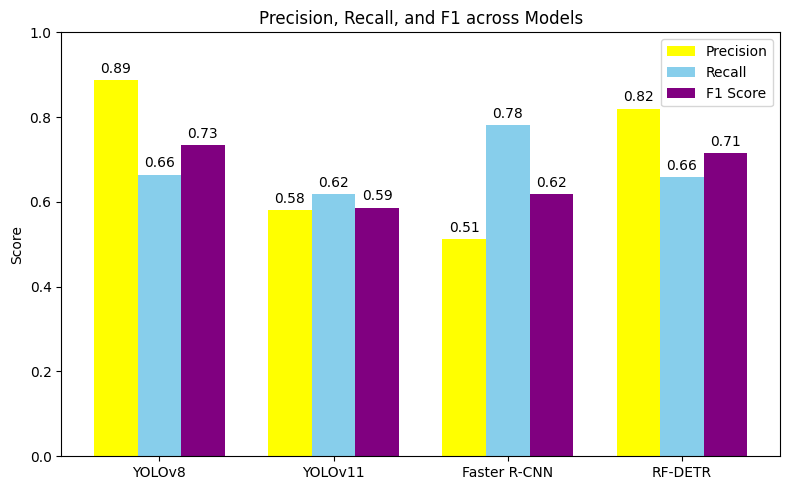

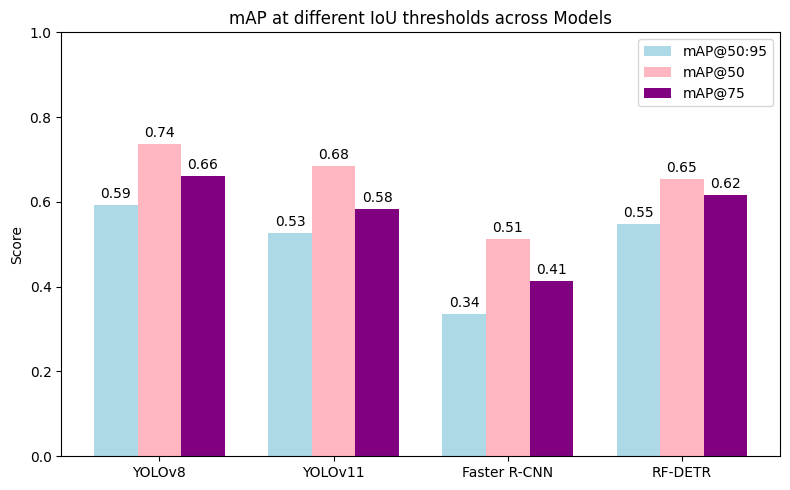

In [25]:
# Metrics
%matplotlib inline

models = ["YOLOv8", "YOLOv11", "Faster R-CNN", "RF-DETR"]

# lists with values
precision = [yolov8_metrics.box.mp, yolov11_metrics.box.mp, results_faster_rcnn["precision"], results_rf_detr["precision"]]
recall    = [yolov8_metrics.box.mr, yolov11_metrics.box.mr, results_faster_rcnn["recall"], results_rf_detr["recall"]]
f1        = [mean_f1_v8, mean_f1_v11, results_faster_rcnn["f1"], results_rf_detr["f1"]]

x = np.arange(len(models))  # label locations
width = 0.25                # width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(8,5))

rects1 = ax.bar(x - width, precision, width, label='Precision', color='yellow')
rects2 = ax.bar(x, recall, width, label='Recall', color='skyblue')
rects3 = ax.bar(x + width, f1, width, label='F1 Score', color='purple')

ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1 across Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.0)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

map5095 = [yolov8_metrics.box.map, yolov11_metrics.box.map, results_faster_rcnn["mAP5095"], results_rf_detr["mAP5095"]]
map50   = [yolov8_metrics.box.map50, yolov11_metrics.box.map50, results_faster_rcnn["mAP50"], results_rf_detr["mAP50"]]
map77   = [yolov8_metrics.box.map75, yolov11_metrics.box.map75, results_faster_rcnn["mAP75"], results_rf_detr["mAP75"]]

fig, ax = plt.subplots(figsize=(8,5))

rects1 = ax.bar(x - width, map5095, width, label='mAP@50:95', color='lightblue')
rects2 = ax.bar(x, map50, width, label='mAP@50', color='lightpink')
rects3 = ax.bar(x + width, map77, width, label='mAP@75', color='purple')

ax.set_ylabel('Score')
ax.set_title('mAP at different IoU thresholds across Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.0)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()